In [1]:
import sys
sys.path.append("../")

In [2]:
from datetime import datetime
from functools import partial
from matplotlib.dates import DateFormatter
from ta import add_all_ta_features
from ta.utils import dropna
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
keras.config.enable_unsafe_deserialization()

from draw_image_utils import draw_prediction

In [3]:
symbol_mapping = {
    "CTG": {
        "dataset_folder": "ctg_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend_1_1_1_1_1_1_1_1",
        "freq_of_date": "B"
    },
    "FPT": {
        "dataset_folder": "fpt_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend_1",
        "freq_of_date": "B"
    },
    "TCB": {
        "dataset_folder": "tcb_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend_1_1_1",
        "freq_of_date": "B"
    },
    "VN30": {
        "dataset_folder": "vn30_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend_1_1",
        "freq_of_date": "B"
    },
    # "BTC": {
    #     "dataset_folder": "btc_with_ema_macd_trend",
    #     "model_name": "model_5_biLSTM_ema_macd_trend",
    #     "freq_of_date": "D"
    # },
    "BTC": {
        "dataset_folder": "btc_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend",
        "freq_of_date": "D"
    },
    "ETH": {
        "dataset_folder": "eth_with_ema_macd_trend",
        "model_name": "channels_to_time_step_attention_ema_macd_trend_1_1_1",
        "freq_of_date": "D"
    },
    "COCA_COLA": {
        "dataset_folder": "coca_cola_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend_1_1_1",
        "freq_of_date": "D"
    },
    "APPLE": {
        "dataset_folder": "apple_with_ema_macd_trend",
        "model_name": "model_5_biLSTM_ema_macd_trend_1_1",
        "freq_of_date": "D"
    },
}

In [4]:
symbol = input("Symbol = ").strip().upper()
dataset_folder_name = symbol_mapping[symbol]["dataset_folder"]
model_name = symbol_mapping[symbol]["model_name"]
dataset_folder = f"../dataset/{dataset_folder_name}"
index_of_image_input = 3
batch_size = 100
freq_of_date = symbol_mapping[symbol]["freq_of_date"] # B or D

config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [5]:
function_transform_origin = get_origin_transform_function(
    os.path.join(
        os.path.abspath(f"{dataset_folder}/model_save/{model_name}"),
        "config_and_loss.json"
    )
)
path_of_model = f"{dataset_folder}/model_save/{model_name}/{model_name}.keras"
model = keras.models.load_model(os.path.abspath(path_of_model))


In [6]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)


In [7]:
image_shape = get_image_shape(dataset_test, index_of_image_input)

In [8]:
config_of_continue_learning_folder = read_config(dataset_folder)
file_csv_path = config_of_continue_learning_folder["file_csv"]
df_get_from_api = pd.read_csv(file_csv_path)
df_get_from_api["Date"] = pd.to_datetime(df_get_from_api["Date"])

In [9]:
def date_generator(date_i):
    index_of_date = get_date_index(df_get_from_api, date_i)
    total_days = previous_days + 1 + next_days + days_result
    all_dates = df_get_from_api[index_of_date:index_of_date + total_days]["Date"].dt.date
    total_date_reals = len(all_dates)
    dates_real = all_dates
    if len(all_dates) < total_days:
        all_dates = pd.date_range(start=str(date_i), periods=total_days, freq=freq_of_date)
    return list(all_dates), total_date_reals

In [10]:
dataset_test_1 = dataset_test
dataset_test_2 = dataset_test_1.batch(batch_size)
transform_function = partial(function_transform_origin, days_result)
dataset_test_3 = dataset_test_2.map(transform_function)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 287, 287,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 286, 286,  │        104 │ image_input[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 285, 285,  │         99 │ conv2d_2[0][0]    │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 142, 142,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_3 (Permute) │ (None, 3, 142,    │          0 │ max_pooling2d_1[… │
│                     │ 142)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ema_9_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macd_history_input  │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trend_type_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 3, 20164)  │          0 │ permute_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │         24 │ ema_9_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 8)         │         24 │ macd_history_inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │         16 │ trend_type_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 3, 64)     │  1,290,560 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 3, 8)      │          0 │ dense_9[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 3, 8)      │          0 │ dense_10[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 3, 8)      │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 3, 64)     │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3, 88)     │          0 │ repeat_vector_4[

 Total params: 4,594,060 (17.52 MB)

 Trainable params: 1,531,353 (5.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,062,707 (11.68 MB)

In [12]:
loss = model.evaluate(dataset_test_3)

d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 6.8052 - mae: 1.7589 - mse: 6.8052


In [13]:
loss

[7.060087203979492, 1.7850438356399536, 7.060087203979492]

In [14]:
prediction_for_test = model.predict(dataset_test_3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step


In [15]:
print(prediction_for_test)

[[[ 0.5884211  -1.2246279 ]
  [ 0.19600049  0.15849549]
  [ 0.16507488  0.27392238]]

 [[-0.762571   -1.7061895 ]
  [ 0.1232253   0.1616566 ]
  [-0.00947893  0.25432998]]

 [[ 1.0786664   2.1368802 ]
  [ 0.2496268   0.23685105]
  [ 0.24366233  0.23304822]]

 ...

 [[-1.4360571  -1.8053576 ]
  [ 0.10187358  0.16994643]
  [-0.06161097  0.22455408]]

 [[-1.6582607  -1.8342344 ]
  [ 0.10063528  0.1710445 ]
  [-0.06531325  0.2116267 ]]

 [[-0.24851272 -1.5140413 ]
  [ 0.15744016  0.15186884]
  [ 0.05920628  0.26172805]]]


In [16]:
len(prediction_for_test)

231

In [17]:
all_dates = unwrap_dataset_at_index(dataset_test, 5, to_numpy=True, map_function=lambda date: str(datetime.fromisoformat(date.decode("utf-8")).date()))
trend_dataset_test_2 = unwrap_dataset_at_index(unwrap_dataset_at_index(dataset_test_2, 2, batch=True, to_numpy=True), 0)
_4_prices_of_all_days_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 4, batch=True, to_numpy=True)
image_input_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 3, batch=True, to_numpy=True)
real_percent_last_days_result_dataset_test_3 = unwrap_dataset_at_index(dataset_test_3, 1, batch=True, to_numpy=True) 

In [18]:
mapping_trend_type = {
    1: "GROUP_BULL",
    -1: "GROUP_BEAR",
    0: "GROUP_SIZEWAY",
}

real: [[ 7.00154834e+00  2.96000542e+00]
 [ 1.32796694e-03  1.49600605e+00]
 [-4.10259036e+00 -2.08955134e-04]]
prediction: [[1.0786664  2.1368802 ]
 [0.2496268  0.23685105]
 [0.24366233 0.23304822]]


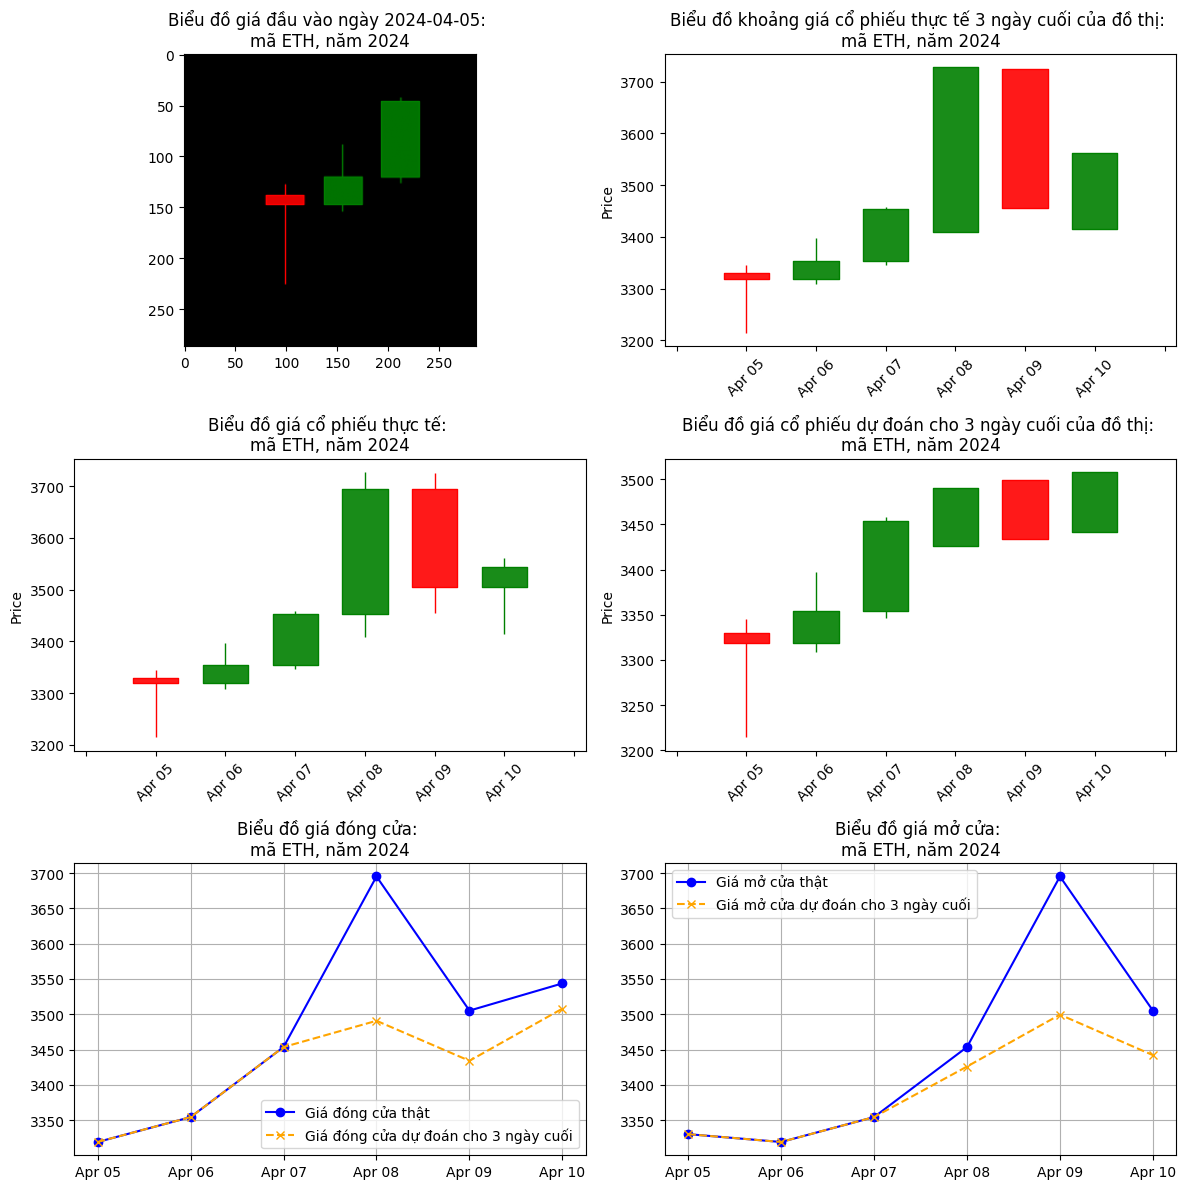

In [19]:
index = 2
print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
print(f"prediction: {prediction_for_test[index]}")
type_of_output = "open_and_close"
draw_prediction(
    image_input_dataset_test_2[index], 
    _4_prices_of_all_days_dataset_test_2[index], 
    all_dates[index],
    prediction_for_test[index], 
    show_x_orginal_candle=True,
    show_prediction_candle=True, 
    show_original_candle=True,
    show_close_compare=True,
    show_open_compare=True,
    type_of_output=type_of_output,
    draw_beside=True,
    print_image=True,
    extend_real=True,
    date_generator=date_generator,
    symbol=symbol)

In [24]:
# index = 0
is_print_all = input("Print all? (y/n): ").lower()[0] == "y"
type_of_output = "open_and_close"
if is_print_all:
    group = input("Group to print? (bull/bear/sizeway/all) ").strip().lower()
    is_extend_real = input("Extend real? (y/n): ").strip().lower()[0] == "y"
    if "bull" in group:
        group = "GROUP_BULL"
    elif "bear" in group:
        group = "GROUP_BEAR"
    elif "sizeway" in group:
        group = "GROUP_SIZEWAY"
    elif len(group) == 0 or "all" in group:
        group = None
        
    folder_name = f"{model_name}"
    if group is not None:
        folder_name += f"/{group}"
    
    if is_extend_real:
        folder_name = f"extend_real_{folder_name}"
    folder_save_image_predict = f"{dataset_folder}/output_prediction_image/{folder_name}"
    
    os.makedirs(folder_save_image_predict, exist_ok=False)
    
    date_printed = set()
    for index in range(len(_4_prices_of_all_days_dataset_test_2)):
        if index % 10 == 0:
            print(f"---------------- Save: {index}/{len(_4_prices_of_all_days_dataset_test_2)} images")
        print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
        print(f"prediction: {prediction_for_test[index]}")
        date = all_dates[index]
        if date in date_printed:
            continue
        else:
            date_printed.add(date)
        
        trend_type = mapping_trend_type[trend_dataset_test_2[index]]
        
        if group is not None:
            if trend_type != group:
                continue
        
        draw_prediction(
            image_input_dataset_test_2[index], 
            _4_prices_of_all_days_dataset_test_2[index], 
            date,
            prediction_for_test[index], 
            show_x_orginal_candle=True,
            show_prediction_candle=True, 
            show_original_candle=True,
            show_close_compare=True,
            show_open_compare=True,
            type_of_output=type_of_output,
            draw_beside=True,
            save_image=f"{folder_save_image_predict}/{date}_{trend_type}_predict.png",
            print_image=False,
            extend_real=is_extend_real,
            date_generator=date_generator,
            symbol=symbol)

---------------- Save: 0/231 images
real: [[ 0.01353175 -0.44592729]
 [ 2.15463766 -0.00945322]
 [ 1.18380161  2.67791555]]
prediction: [[ 0.5884211  -1.2246279 ]
 [ 0.19600049  0.15849549]
 [ 0.16507488  0.27392238]]
real: [[1.59580711 0.0241212 ]
 [3.99428356 1.941784  ]
 [0.04118288 1.88071412]]
prediction: [[-0.762571   -1.7061895 ]
 [ 0.1232253   0.1616566 ]
 [-0.00947893  0.25432998]]
real: [[ 7.00154834e+00  2.96000542e+00]
 [ 1.32796694e-03  1.49600605e+00]
 [-4.10259036e+00 -2.08955134e-04]]
prediction: [[1.0786664  2.1368802 ]
 [0.2496268  0.23685105]
 [0.24366233 0.23304822]]
real: [[ 1.91384128e+00  1.98951245e-04]
 [ 9.31778174e-01  5.07332955e+00]
 [-3.97917414e-03 -7.33884532e-01]]
prediction: [[-0.16060662 -1.5957121 ]
 [ 0.16437522  0.14982224]
 [ 0.07101358  0.26671287]]
real: [[ 6.31791243e-05 -2.50444265e-02]
 [-1.36112388e+00 -3.48873436e+00]
 [-3.42936826e+00 -3.34026540e-02]]
prediction: [[1.2847779  1.49746   ]
 [0.24938619 0.24434724]
 [0.24982789 0.23732267]]


In [25]:
folder_save_image_predict

'../dataset/eth_with_ema_macd_trend/output_prediction_image/extend_real_channels_to_time_step_attention_ema_macd_trend_1_1_1/GROUP_SIZEWAY'